In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

# Defining Tools

In [2]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents.tools import tool
from langchain_community.tools import WikipediaQueryRun, BraveSearch
from langchain_community.document_loaders import WebBaseLoader

import json
import requests
from typing import List # Import List for type hinting in brave_search

api_key = os.getenv("OPENWEATHERMAP_API_KEY")

# weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=api_key) # This line is not directly used, so it can be commented out or removed if not needed elsewhere.

os.environ['BRAVE_SEARCH_API_KEY'] = os.getenv("BRAVE_API_KEY")


@tool
def brave_search(question: str) -> List[str]:
    """
    Perform a web search using Brave Search and return content from the top result pages.

    This tool fetches live data from the internet using the Brave Search engine. It extracts
    links from the search results for a given query, loads the content from those pages,
    and returns the cleaned text content for further processing.

    Args:
        question (str): A search query string (e.g., "famous attractions in Kerala").

    Returns:
        List[str]: A list of cleaned text content extracted from the top web pages returned by the search.
    """
    brave = BraveSearch(description="To search over internet about anything")
    # MODIFICATION: Use the 'question' argument dynamically
    res = brave.run(question).lstrip()

    urls = [result['link'] for result in json.loads(res)]


    docs = WebBaseLoader(web_paths=urls).load()
    text = [doc.page_content.replace('\\n',"").strip() for doc in docs]

    return text


def get_coordinates(city: str):
    geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1"
    response = requests.get(geo_url).json()
    if "results" not in response or len(response["results"]) == 0:
        return None, None
    loc = response["results"][0]
    return loc["latitude"], loc["longitude"]

@tool
def get_weekly_weather(city: str, start_date: str, end_date: str) -> str:
    """
    Retrieve a daily weather forecast summary for a specific city over a given date range.

    This tool fetches the 7-day weather forecast using the Open-Meteo API. It includes:
    - Minimum and maximum temperatures
    - Daily precipitation
    - Date-wise summary for the specified period

    Steps performed:
    1. Geocodes the city name into latitude and longitude using Open-Meteo Geocoding API.
    2. Calls the Open-Meteo Forecast API with daily weather parameters.
    3. Formats the response into a human-readable forecast report.

    Args:
        city (str): Name of the city to retrieve the weather for.
        start_date (str): Start date of the forecast in 'YYYY-MM-DD' format.
        end_date (str): End date of the forecast in 'YYYY-MM-DD' format.

    Returns:
        str: A formatted weather report or an error message if data is unavailable.
    """

    print("\n ------------Getting Weather Forecast------------------- \n")

    # Step 1: Get latitude and longitude
    lat, lon = get_coordinates(city)
    if lat is None or lon is None:
        weather_forecast = f"❌ Could not find location: {city}"
        return weather_forecast

    # Step 2: Call Open-Meteo API with date range
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_min,temperature_2m_max,precipitation_sum,weathercode"
        f"&timezone=auto"
    )
    res = requests.get(url).json()

    # Step 3: Build forecast output
    if "daily" not in res:
        weather_forecast  = f"❌ Weather forecast not available for {city}."
        return weather_forecast

    daily = res["daily"]
    forecast = f"📍 Weather Forecast for {city.title()} ({start_date} to {end_date}):\n"
    for i in range(len(daily["time"])):
        date = daily["time"][i]
        tmin = daily["temperature_2m_min"][i]
        tmax = daily["temperature_2m_max"][i]
        rain = daily["precipitation_sum"][i]
        forecast += f"{date}: 🌡️ {tmin}°C – {tmax}°C, 🌧️ {rain}mm\n"


    return forecast


wiki_wrapper = WikipediaAPIWrapper()
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

tools = [brave_search, wiki_tool, get_weekly_weather]

USER_AGENT environment variable not set, consider setting it to identify your requests.


# Loading The model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
llm = ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', api_key=GEMINI_API_KEY)

# Binding the tools

In [4]:
llm_with_tools = llm.bind_tools(tools=tools)

# state initialization

In [1]:
from langgraph.graph import MessagesState

# Adding Planner Functionality

In [88]:
from langchain.prompts import PromptTemplate

def planner(state: MessagesState) -> MessagesState:
   

    prompt = """You are an AI Travel Planner and Expense Manager. Your task is to assist users in planning trips to any city worldwide using reasoning and tools.
                use the tools appropriate while answering
                Give the detailed iternary for the provided duration which includes for each day:
                - attractions and activities in places
                - restaurants
                - transportation
                - hotel stays
                - wheather forecast
                to get data about hotels , restuarants,transportation at city and famous places use brave_search tool or wiki_tool"""


    # The planner function will now effectively leverage the tools based on the improved prompt
    response = llm_with_tools.invoke([prompt]+state['messages'])
    print(response)

    state['messages'] = [response]

    return {**state}

# Creating Graph

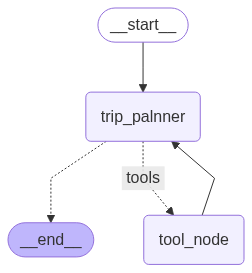

In [89]:
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode,tools_condition

workflow = StateGraph(MessagesState)

workflow.add_node('trip_palnner',planner)
workflow.add_node('tool_node',ToolNode(tools))

workflow.set_entry_point('trip_palnner')

workflow.add_conditional_edges(
    'trip_palnner',
    tools_condition,
    {
        'tools':'tool_node',
        END:END
    }
)

workflow.add_edge('tool_node','trip_palnner')

app = workflow.compile()

app

In [90]:
state = {'messages':[""" I am planning a trip from Allagadda to Kerala from June 25 to June 31, 2025. My total budget is ₹15,000. Please provide a well-planned and budget-friendly itinerary that includes:
                     - Transportation from Allagadda to Kerala and back
                     - Accommodation for the entire stay
                     - Daily food expenses
                     - A list of must-visit tourist attractions in Kerala (with an optimal route)
                     - Local transportation between places
                     Please ensure the plan stays within my ₹15,000 budget."""]}
resp = app.invoke(state)

content="Okay, I can help you plan a budget-friendly trip from Allagadda to Kerala from June 25 to June 31, 2025, within your ₹15,000 budget. Let's break down the plan:\n\n**1. Transportation from Allagadda to Kerala and Back:**\n\n*   **Option:** Since your budget is tight, the most economical option is likely train travel.\n*   **Action:** I will use a web search to find train routes and prices from nearby major railway stations to Kerala." additional_kwargs={'function_call': {'name': 'brave_search', 'arguments': '{"question": "train routes from major railway stations near Allagadda to Kerala and prices"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--5e70eddc-18c6-469a-a660-e592545a20fe-0' tool_calls=[{'name': 'brave_search', 'args': {'question': 'train routes from major railway stations near Allagadda to Kerala and prices'}, 'id': '183012cc-9737-4caf-8dc8-5

In [91]:
resp['messages']

[HumanMessage(content=' I am planning a trip from Allagadda to Kerala from June 25 to June 31, 2025. My total budget is ₹15,000. Please provide a well-planned and budget-friendly itinerary that includes:\n                     - Transportation from Allagadda to Kerala and back\n                     - Accommodation for the entire stay\n                     - Daily food expenses\n                     - A list of must-visit tourist attractions in Kerala (with an optimal route)\n                     - Local transportation between places\n                     Please ensure the plan stays within my ₹15,000 budget.', additional_kwargs={}, response_metadata={}, id='afdcefb4-2a0a-4a09-a721-c65b2fa0d225'),
 AIMessage(content="Okay, I can help you plan a budget-friendly trip from Allagadda to Kerala from June 25 to June 31, 2025, within your ₹15,000 budget. Let's break down the plan:\n\n**1. Transportation from Allagadda to Kerala and Back:**\n\n*   **Option:** Since your budget is tight, the most

In [92]:
for m in resp['messages']:
     m.pretty_print()

================================ Human Message =================================

 I am planning a trip from Allagadda to Kerala from June 25 to June 31, 2025. My total budget is ₹15,000. Please provide a well-planned and budget-friendly itinerary that includes:
                     - Transportation from Allagadda to Kerala and back
                     - Accommodation for the entire stay
                     - Daily food expenses
                     - A list of must-visit tourist attractions in Kerala (with an optimal route)
                     - Local transportation between places
                     Please ensure the plan stays within my ₹15,000 budget.
================================== Ai Message ==================================

Okay, I can help you plan a budget-friendly trip from Allagadda to Kerala from June 25 to June 31, 2025, within your ₹15,000 budget. Let's break down the plan:

**1. Transportation from Allagadda to Kerala and Back:**

*   **Option:** Since your budg